<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Description</a></span></li><li><span><a href="#Business-Problem" data-toc-modified-id="Business-Problem-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Business Problem</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Useful-Scripts" data-toc-modified-id="Useful-Scripts-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Useful Scripts</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Data Processing</a></span><ul class="toc-item"><li><span><a href="#create-virtual-columns" data-toc-modified-id="create-virtual-columns-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>create virtual columns</a></span></li><li><span><a href="#Categorize-features" data-toc-modified-id="Categorize-features-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Categorize features</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Correlations" data-toc-modified-id="Correlations-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Correlations</a></span></li><li><span><a href="#Scatter-plots" data-toc-modified-id="Scatter-plots-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Scatter plots</a></span></li><li><span><a href="#Barplots" data-toc-modified-id="Barplots-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Barplots</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#Modelling-LightGBM-using-Vaex" data-toc-modified-id="Modelling-LightGBM-using-Vaex-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Modelling LightGBM using Vaex</a></span></li><li><span><a href="#Predictions" data-toc-modified-id="Predictions-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Predictions</a></span></li><li><span><a href="#Model-Performances" data-toc-modified-id="Model-Performances-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Model Performances</a></span></li></ul></li></ul></div>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel,  Data Scientist, Ph.D Astrophysics</a> .
</div>

# Data Description

> The datasets contains transactions made by credit cards in September
2013 by european cardholders.


> This dataset presents transactions that occurred in two days,
where we have 492 frauds out of 284,807 transactions. 

> The dataset is highly unbalanced, the positive class (frauds)
account for 0.172% of all transactions.

> It contains only numerical input variables which are
the result of a PCA transformation.


> Unfortunately, due to confidentiality issues,
we cannot provide the original features and 
more background information about the data.


> Features V1, V2, ... V28 are the principal
components obtained with PCA,
the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

> Feature 'Time' contains the seconds elapsed between each transaction
and the first transaction in the dataset. The feature 'Amount'
is the transaction Amount, this feature can be used for 
example-dependant cost-senstive learning. 

> Feature 'Class' is the response variable and it takes value
1 in case of fraud and 0 otherwise.

# Business Problem

<div class="alert alert-block alert-success">
<b>Business Problem:</b>  <br>
Task &nbsp;&nbsp; : Detect the fraudulent activities. <br>
Metric : Recall <br>
Question: How many frauds are correctly classified? <br>
Method Used: Vaex ( which works for big data ~ 1 billion rows)
</div>

Here, in this notebook I use the big data analysiz tool called [vaex](https://github.com/vaexio/vaex) (pronounced as VEX).
This is acronym of visualizatoin and exploration library mainly created to
visualize GAIA Telescopic data visualization but later further developed
to include dataframe and some machine leaning models.

Vaex uses memory mapping, and stunningly fast. One thing I like about
vaex is that it records all the states (whatever actions we did to the
dataframe) and we can use the same state to TEST data for machine learning
modelling.

As like Spark, vaex dataframes are immutable. In vaex we create new virtual
columns using some expressions. Those expressions can be any mathematical
operations such as np.sqrt and so on.

Like tensorflow uses compuatation, vaex uses mmap and does lazy operations,
this means evaluation is done only if necessary.

- Vaex supports many scikit-learn models
- Vaex supports various boosting modules lightgbm, xgboost, catboost, annoy

Now, without a further ado, let's do some data science with it.

# Imports

In [106]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

import os
import time

# random state
SEED = 0
RNG = np.random.RandomState(SEED)

In [2]:
# my personal library
from bhishan import bp
from bhishan.bp import show_method_attributes

In [121]:
# import big data module vaex
import vaex as vx
import vaex.ml
import vaex.ml.lightgbm
import lightgbm as lgb

vx.__version__

'1.0.0-beta.6'

In [5]:
from tqdm import tqdm, tqdm_notebook, tnrange
import ipywidgets as widgets

In [6]:
import bqplot as bq

# Useful Scripts

In [7]:
df_eval = pd.DataFrame({
    'model_name':[],
    'desc':[],
    'f1':[],
    'weightedPrecision':[],
    'weightedRecall':[],
    'accuracy':[],
    'areaUnderROC':[],
    'areaUnderPR':[]
})

df_eval

,model_name,desc,f1,weightedPrecision,weightedRecall,accuracy,areaUnderROC,areaUnderPR


# Load the data

In [8]:
%%bash
# unzip ../data/raw/creditcard.csv.zip -d ../data/raw/
ls ../data/raw

creditcard.csv
creditcard.csv.zip
creditcard.hdf5


In [9]:
ifile = "../data/raw/creditcard.csv"

In [10]:
%%bash
head -3 $ifile

In [11]:
%%bash
head -5 $ifile | cut -d ',' -f 1
tail -5 $ifile | cut -d ',' -f 1

tail -5 $ifile | cut -d '


In [12]:
bp.show_method_attributes(vx,4)

Object Type: <class 'module'>



,0,1,2,3
0,BinnerTime,format,kld,set_log_level_exception
1,GroupBy,from_arrays,loader,set_log_level_info
2,Grouper,from_arrow_table,logger,set_log_level_off
3,add_namespace,from_ascii,logging,set_log_level_warning
4,agg,from_astropy_table,multithreading,settings
5,aliases,from_csv,open,six
6,app,from_dict,open_many,stat
7,astro,from_items,parse_qs,string_column
8,column,from_json,pkg_resources,strings
9,concat,from_pandas,print_function,superagg


In [13]:
dfv = vx.read_csv(ifile)
dfv

#,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,index
0,0.0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.33832076994251803,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.31116935369987897,1.46817697209427,-0.47040052525947795,0.20797124192924202,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.12853935827352803,-0.189114843888824,0.13355837674038698,-0.0210530534538215,149.62,0,0
1,0.0,1.1918571113148602,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.16697441400461402,1.6127266610547901,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.463917041022171,-0.114804663102346,-0.18336127012399397,-0.14578304132525902,-0.0690831352230203,-0.225775248033138,-0.6386719527718511,0.10128802125323402,-0.33984647552912706,0.167170404418143,0.125894532368176,-0.00898309914322813,0.0147241691924927,2.69,0,1
2,1.0,-1.35835406159823,-1.3401630747360902,1.77320934263119,0.3797795930343279,-0.503198133318193,1.80049938079263,0.7914609564504219,0.24767578658899103,-1.5146543226058302,0.207642865216696,0.6245014594248951,0.06608368526883099,0.7172927314108309,-0.165945922763554,2.34586494901581,-2.8900831944423104,1.10996937869599,-0.12135931319588801,-2.26185709530414,0.524979725224404,0.247998153469754,0.771679401917229,0.9094122623477191,-0.689280956490685,-0.3276418337352511,-0.139096571514147,-0.0553527940384261,-0.0597518405929204,378.66,0,2
3,1.0,-0.9662717115720871,-0.185226008082898,1.79299333957872,-0.863291275036453,-0.0103088796030823,1.24720316752486,0.23760893977178,0.377435874652262,-1.38702406270197,-0.0549519224713749,-0.22648726383540102,0.178228225877303,0.507756869957169,-0.28792374549456,-0.631418117709045,-1.0596472454324999,-0.684092786345479,1.96577500349538,-1.2326219700892,-0.208037781160366,-0.108300452035545,0.0052735967825345295,-0.190320518742841,-1.1755753318632098,0.647376034602038,-0.22192884445840697,0.0627228487293033,0.0614576285006353,123.5,0,3
4,2.0,-1.1582330934952298,0.8777367548484508,1.548717846511,0.40303393395512105,-0.40719337731165295,0.0959214624684256,0.5929407453855451,-0.27053267719228197,0.8177393082352941,0.7530744319763539,-0.8228428779463629,0.53819555014995,1.3458515932154,-1.11966983471731,0.175121130008994,-0.451449182813529,-0.237033239362776,-0.0381947870352842,0.803486924960175,0.40854236039275804,-0.009430697132329191,0.7982784945897099,-0.13745807961906303,0.14126698382476902,-0.20600958761975602,0.502292224181569,0.219422229513348,0.21515314749920603,69.99,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"284,802",172786.0,-11.881117885432301,10.0717849710003,-9.83478345739033,-2.0666556845941297,-5.3644727809758495,-2.6068373309456,-4.91821543115252,7.305334020798,1.9144282734458,4.35617041320691,-1.59310526246153,2.7119407910571702,-0.68925560917964,4.62694202525016,-0.92445871482528,1.10764060095394,1.9916911070624297,0.5106323291306479,-0.6829196803569161,1.4758291346555001,0.21345410843735896,0.111863735978609,1.01447989719391,-0.509348453168509,1.4368069070214,0.250034279569581,0.943651171507532,0.8237309614865022,0.77,0,284802
"284,803",172787.0,-0.7327886706589559,-0.0550804899173326,2.03502974528243,-0.7385885843874399,0.868229398914682,1.05841527222565,0.0243296959175797,0.294868698501783,0.584800017281683,-0.9759260633225079,-0.15018884710327599,0.9158019144035551,1.21475584849424,-0.6751429558095761,1.16493090944588,-0.7117573499788811,-0.025692855268572002,-1.22117885840624,-1.54555608554509,0.0596158998872689,0.214205341747019,0.924383584903381,0.0124630383316793,-1.01622566

In [14]:
# show_method_attributes(dfv,5)

In [15]:
show_method_attributes(dfv,5,inside='plot')

Object Type: <class 'vaex.dataframe.DataFrameArrays'>



,0,1,2,3,4
0,healpix_plot,plot1d,plot2d_tensor,plot3d,plot_widget
1,plot,plot2d_contour,plot2d_vector,plot_bq,


In [16]:
# dfv.shape # AttributeError

In [17]:
len(dfv)

284807

In [18]:
len(dfv.columns)

32

In [19]:
np.array(dfv.get_column_names())

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class', 'index'], dtype='<U6')

In [20]:
np.array(list(dfv.columns))

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class', 'index'], dtype='<U6')

In [21]:
dfv.info()

column,type,unit,description,expression
Time,float64,,,
V1,float64,,,
V2,float64,,,
V3,float64,,,
V4,float64,,,
V5,float64,,,
V6,float64,,,
V7,float64,,,
V8,float64,,,
V9,float64,,,


In [22]:
dfv.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,index
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
count,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,...,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807
NA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mean,94813.85957508067,3.919560084655042e-15,5.688174400270728e-16,-8.76907126289773e-15,2.782312291808533e-15,-1.5525630329923732e-15,2.010663493875542e-15,-1.694249132734738e-15,-1.9270277088072758e-16,-3.13702431282631e-15,...,7.959908529993057e-16,5.367589788427716e-16,4.4581115101841816e-15,1.453003365084085e-15,1.6991042900067526e-15,-3.660160614016803e-16,-1.206048852934382e-16,88.34961925087359,0.001727485630620034,142403.0
std,47488.1,1.95869,1.65131,1.51625,1.41587,1.38024,1.33227,1.23709,1.19435,1.09863,...,0.7257,0.624459,0.605646,0.521277,0.482226,0.403632,0.330083,250.12,0.0415271,82216.7
min,0,-56.4075,-72.7157,-48.3256,-5.68317,-113.743,-26.1605,-43.5572,-73.2167,-13.4341,...,-10.9331,-44.8077,-2.83663,-10.2954,-2.60455,-22.5657,-15.4301,0,0,0
max,172792,2.45493,22.0577,9.38256,16.8753,34.8017,73.3016,120.589,20.0072,15.595,...,10.5031,22.5284,4.58455,7.51959,3.51735,31.6122,33.8478,25691.2,1,284806


In [23]:
ifile = ifile.replace('.csv','.hdf5')
dfv.export_hdf5(ifile, virtual=True)

In [24]:
!ls ../data/raw

creditcard.csv     creditcard.csv.zip creditcard.hdf5


In [25]:
dfv = vx.open(ifile)

In [26]:
dfv.head(1)

#,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,index
0,0,-1.35981,-0.0727812,2.53635,1.37816,-0.338321,0.462388,0.239599,0.0986979,0.363787,0.0907942,-0.5516,-0.617801,-0.99139,-0.311169,1.46818,-0.470401,0.207971,0.0257906,0.403993,0.251412,-0.0183068,0.277838,-0.110474,0.0669281,0.128539,-0.189115,0.133558,-0.0210531,149.62,0,0


# Data Processing

## create virtual columns

In [27]:
np.array(list(dfv.columns))

array(['Amount', 'Class', 'Time', 'V1', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V2', 'V20', 'V21', 'V22',
       'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V3', 'V4', 'V5', 'V6',
       'V7', 'V8', 'V9', 'index'], dtype='<U6')

In [28]:
dfv['log1p_Amount'] = np.log1p(dfv['Amount'])
dfv['log1p_Time'] = np.log1p(dfv['Amount'])

In [29]:
np.array(list(dfv.columns))

array(['Amount', 'Class', 'Time', 'V1', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V2', 'V20', 'V21', 'V22',
       'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V3', 'V4', 'V5', 'V6',
       'V7', 'V8', 'V9', 'index'], dtype='<U6')

In [30]:
dfv[['log1p_Amount','log1p_Time']].head(2)

#,log1p_Amount,log1p_Time
0,5.01476,5.01476
1,1.30563,1.30563


## Categorize features

In [31]:
dfv.categorize(column='Class')

# EDA

In [32]:
dfv.select(dfv['Class']==0, name='class_0')

dfv.mean(dfv.Amount, selection=['class_0'])

array([88.29102242])

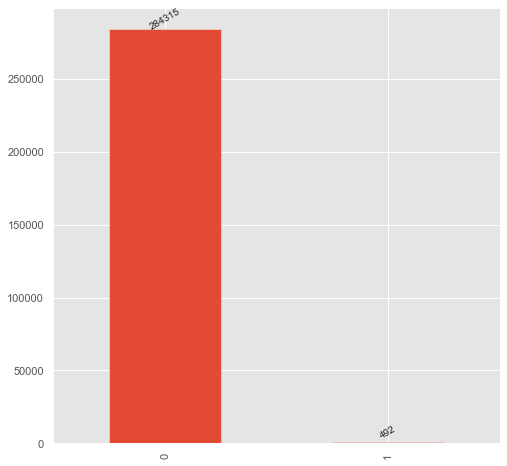

In [33]:
ax = dfv['Class'].value_counts().plot.bar()
bp.add_text_barplot(ax)

In [34]:
pca_vars = ['V%i' % k for k in range(1,29)]
dfv[pca_vars].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
count,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,...,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807
NA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mean,3.919560084655042e-15,5.688174400270728e-16,-8.76907126289773e-15,2.782312291808533e-15,-1.5525630329923732e-15,2.010663493875542e-15,-1.694249132734738e-15,-1.9270277088072758e-16,-3.13702431282631e-15,1.7686271795410151e-15,...,9.04973248757329e-16,5.085503396752038e-16,1.5372936510804693e-16,7.959908529993057e-16,5.367589788427716e-16,4.4581115101841816e-15,1.453003365084085e-15,1.6991042900067526e-15,-3.660160614016803e-16,-1.206048852934382e-16
std,1.95869,1.65131,1.51625,1.41587,1.38024,1.33227,1.23709,1.19435,1.09863,1.08885,...,0.814039,0.770924,0.734523,0.7257,0.624459,0.605646,0.521277,0.482226,0.403632,0.330083
min,-56.4075,-72.7157,-48.3256,-5.68317,-113.743,-26.1605,-43.5572,-73.2167,-13.4341,-24.5883,...,-7.21353,-54.4977,-34.8304,-10.9331,-44.8077,-2.83663,-10.2954,-2.60455,-22.5657,-15.4301
max,2.45493,22.0577,9.38256,16.8753,34.8017,73.3016,120.589,20.0072,15.595,23.7451,...,5.59197,39.4209,27.2028,10.5031,22.5284,4.58455,7.51959,3.51735,31.6122,33.8478


In [35]:
# dfv.mean?

In [36]:
dfv.Amount.mean()

array(88.34961925)

## Correlations

In [37]:
subspaces = dfv.combinations()
correlations = dfv.correlation(subspaces)
mutual_informations = dfv.mutual_information(subspaces)
names = ["_".join(subspace) for subspace in subspaces]

df_corr = pd.DataFrame({'names': names, 
                       'corr': correlations,
                       'mutual_info': mutual_informations})

df_corr.head()

,names,corr,mutual_info
0,Time_V1,0.117396,0.371445
1,Time_V2,-0.010593,0.111086
2,Time_V3,-0.419618,0.283335
3,Time_V4,-0.105260,0.186229
4,Time_V5,0.173072,0.140498


## Scatter plots

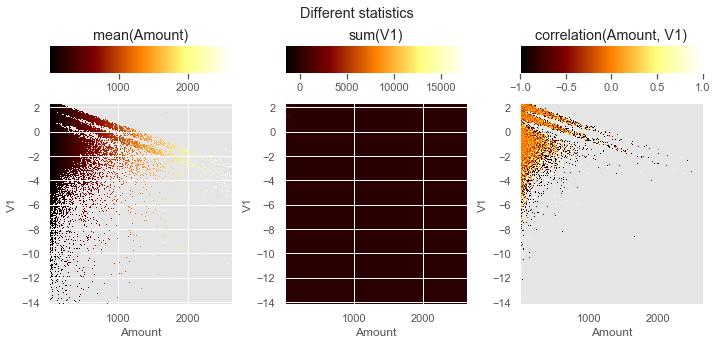

In [60]:
dfv.plot("Amount", "V1",
         what=["mean(Amount)", "sum(V1)", "correlation(Amount, V1)"],
         title="Different statistics",
         figsize=(10,5));

plt.grid(False)

/Users/poudel/miniconda3/envs/xx/lib/python3.7/site-packages/vaex/viz/mpl.py:779: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



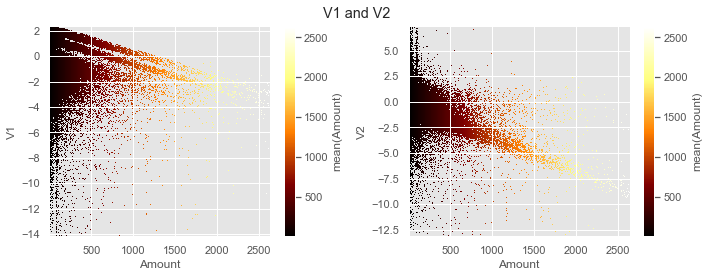

In [45]:
dfv.plot([["Amount", "V1"], ["Amount", "V2"]],
         what=['mean(Amount)'],
         title="V1 and V2",
         figsize=(10,4));

In [100]:
# dfv.plot("Amount", "V1",
#          selection="log1p(Amount)<1",
#          limits=[0,500]
#         );

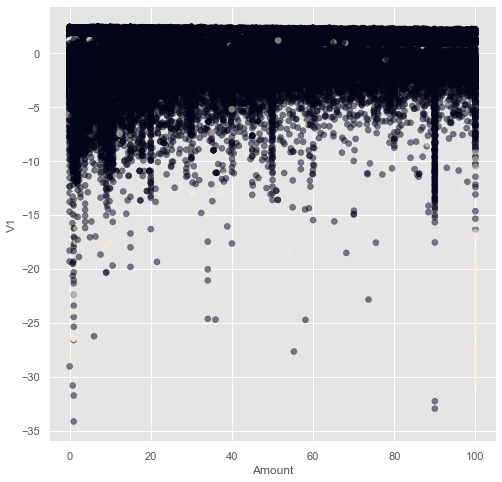

In [81]:
dfv.scatter("Amount", "V1",
            selection="Amount < 100",
            alpha=0.5,
            c=['r','g'],
            c_expr='Class',
            length_check=False # if row > 50k we need this
           );

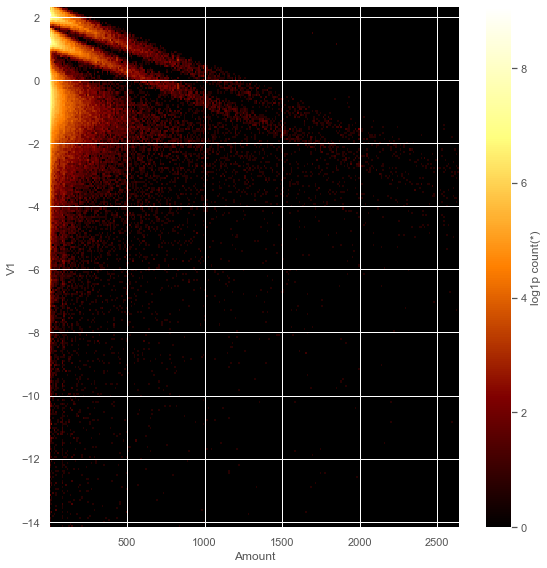

In [84]:
dfv.plot("Amount", "V1", f="log1p");

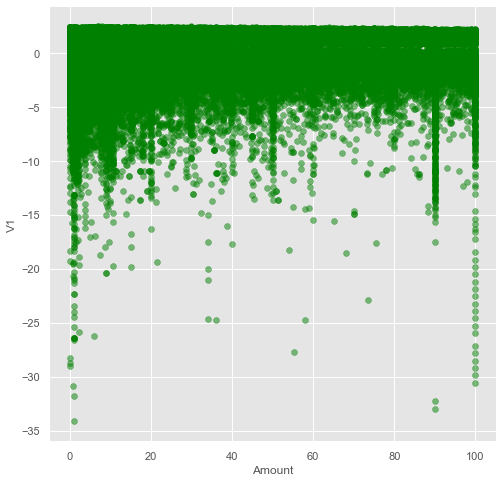

In [85]:
dfv.scatter("Amount", "V1", 
            selection="Amount < 100",
            c="green",
            alpha=0.5,
            length_check=False,
           );

## Barplots

In [95]:
# sns.catplot(x=dfv['Class'].values , kind='count' , palette=['r','g'],)
# This does not work
# TypeError: object of type 'NoneType' has no len()

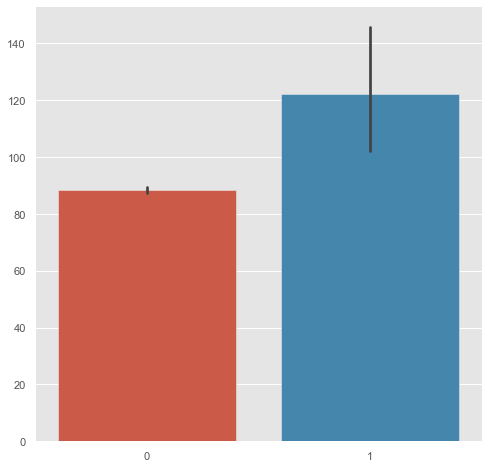

In [94]:
sns.barplot(x=dfv['Class'].values, y=dfv['Amount'].values)

In [97]:
dfv_per_class = dfv.groupby(by=dfv['Class']).agg({
    'Amount': 'sum',
    'V1': 'mean',
    'V2': 'mean'
})

In [98]:
dfv_per_class.Amount.values

array([25102462.03998364,    60127.97      ])

# Modelling

In [99]:
import vaex.ml

In [101]:
bp.show_method_attributes(vaex.ml)

Object Type: <class 'module'>



,0,1,2,3,4,5,6
0,BayesianTargetEncoder,FrequencyEncoder,MaxAbsScaler,PCA,StandardScaler,generate,transformations
1,CycleTransformer,InnerNamespace,MinMaxScaler,Pipeline,WeightOfEvidenceEncoder,pipeline,vaex
2,DataFrameAccessorML,LabelEncoder,OneHotEncoder,RobustScaler,datasets,state,warnings


In [104]:
# dfv.sample?

In [126]:
## Remove Nans
dfv = dfv.dropna()

## Train Test Split

In [109]:
# shuffle the data
dfv = dfv.sample(frac=1,random_state=SEED)

In [110]:
dfv_train = dfv[:int(len(dfv)*0.8)]
dfv_test = dfv[int(len(dfv)*0.8):]

## Modelling LightGBM using Vaex

In [111]:
np.array(dfv.get_column_names())

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class', 'index', 'log1p_Amount', 'log1p_Time'],
      dtype='<U12')

In [130]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'log1p_Amount', 'log1p_Time']

# features

In [131]:
target = 'Class'

In [132]:
bp.show_method_attributes(dfv,4, inside='na')

Object Type: <class 'vaex.dataframe.DataFrameArrays'>



,0,1,2,3
0,column_names,fillna,ordinal_encode,signal_pick
1,combinations,get_column_names,rename_column,signal_selection_changed
2,dropna,length_original,signal_active_fraction_changed,signal_sequence_index_change
3,dropnan,name,signal_column_changed,signal_variable_changed


In [119]:
dfv_train['Class'].value_counts(progress=True)

[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h
 

0    227441
1       404
dtype: int64

In [123]:
params = {'learning_rate': 0.1,
         'max_depth': 5,
          'colsample_bytree': 0.8,
          'subsample': 0.8,
          'reg_alpha': 0,
          'reg_lambda': 1,
          'min_child_weight': 1,
          'objective': 'binary',
          'random_state': SEED,
          'n_jobs': -1
         }

In [125]:
bst = vaex.ml.lightgbm.LightGBMModel(features=features,
                                    params=params,
                                    num_boost_round=100)

In [133]:
dfv_train.head(1)

#,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,index,log1p_Amount,log1p_Time
0,43906,1.22945,-0.235478,-0.627166,0.419877,1.79701,4.06957,-0.896223,1.0361,0.745991,-0.147304,-0.850459,0.397845,-0.259849,-0.277065,-0.76681,-0.200946,-0.338122,0.00603206,0.477431,-0.0579221,-0.17006,-0.28875,-0.13027,1.02593,0.84799,-0.271476,0.0600516,0.0181044,1.99,0,49089,1.09527,1.09527


In [128]:
bst.fit(dfv_train, target=target)

SyntaxError: unexpected EOF while parsing (<string>, line 0)

## Predictions

In [134]:
# ypreds = bst.predic(dfv_train)

In [135]:
from IPython.display import display

In [136]:
# display(ypreds)

In [137]:
# create virtual column
# dfv_train = bst.transform(dfv_train)

# dfv_train.head(2)

## Model Performances

In [140]:
import joblib
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score,precision_score

In [141]:
# # model evaluation
# average = 'binary'
# row_eval = [model_name,desc, 
#             accuracy_score(ytx, ypreds),
#             precision_score(ytx, ypreds, average=average),
#             recall_score(ytx, ypreds, average=average),
#             f1_score(ytx, ypreds, average=average),
#             roc_auc_score(ytx, ypreds),
#             ]

# df_eval.loc[len(df_eval)] = row_eval
# df_eval = df_eval.drop_duplicates()
# time_taken = time.time() - time_start
# print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(time_taken,60)))
# display(df_eval)